# Notebook 3: LQR Optimal Controller

**Objective:** Design and implement Linear Quadratic Regulator (LQR) for optimal beta suppression

**Theory:**
- LQR minimizes quadratic cost function: J = ∫(x'Qx + u'Ru)dt
- Finds optimal control law: u = -Kx
- K computed from Algebraic Riccati Equation
- Guaranteed stability and optimality

**Expected:** 60-70% beta reduction with lower energy consumption than PID

## 1. Setup & Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.linalg import solve_continuous_are
import sys
sys.path.append('..')

# Load baseline data
baseline = np.load('../data/simulation_results/baseline_data.npz')
time = baseline['time']
baseline_beta = baseline['beta_power']
mean_beta = baseline['mean_beta_power']

# Control objective
TARGET_BETA = mean_beta * 0.3

print("✅ Loaded baseline data")
print(f"   Mean beta: {mean_beta:.4f}")
print(f"   Target: {TARGET_BETA:.4f}")

✅ Loaded baseline data
   Mean beta: 0.0366
   Target: 0.0110


## 2. Brain Model (Same as PID)

In [26]:
class SimpleBrainModel:
    """
    Brain model with strong stimulation response
    """
    def __init__(self, baseline_beta, dt=0.001):
        self.baseline_beta = baseline_beta.copy()
        self.time_idx = 0
        
    def step(self, stimulation):
        """Strong response to stimulation"""
        if self.time_idx >= len(self.baseline_beta):
            self.time_idx = len(self.baseline_beta) - 1
        
        natural = self.baseline_beta[self.time_idx]
        
        # STRONG suppression: 25% reduction per mA of stimulation
        beta = natural * (1 - 0.25 * stimulation)
        
        # Keep positive
        beta = max(0.001, beta)
        
        self.time_idx += 1
        return beta
    
    def reset(self):
        self.time_idx = 0

print("✅ High-response brain model created")

✅ High-response brain model created


## 3. System Identification - State-Space Model

For LQR, we need a linear state-space model:
```
dx/dt = Ax + Bu
y = Cx
```

We'll use a simple 2-state model:
- State 1: Beta power deviation from target
- State 2: Rate of change of beta power

In [27]:
# Define state-space matrices for a simple oscillator with damping
# This approximates brain dynamics around the operating point

# System parameters
omega = 2 * np.pi * 20  # Natural frequency (20 Hz - beta band)
zeta = 0.2              # Damping ratio
k_stim = 10.0           # Stimulation effectiveness

# State-space matrices
# States: x1 = beta_error, x2 = d(beta_error)/dt
A = np.array([
    [0,              1],
    [-omega**2,  -2*zeta*omega]
])

# Input matrix (stimulation effect)
B = np.array([
    [0],
    [-k_stim]
])

# Output matrix (we measure beta power)
C = np.array([[1, 0]])

print("📐 State-Space Model:")
print(f"\nA (System dynamics) =\n{A}")
print(f"\nB (Input matrix) =\n{B}")
print(f"\nC (Output matrix) =\n{C}")

# Check controllability
controllability_matrix = np.hstack([B, A @ B])
rank = np.linalg.matrix_rank(controllability_matrix)
print(f"\n✅ System is {'controllable' if rank == 2 else 'NOT controllable'}")
print(f"   Controllability matrix rank: {rank}/2")

📐 State-Space Model:

A (System dynamics) =
[[ 0.00000000e+00  1.00000000e+00]
 [-1.57913670e+04 -5.02654825e+01]]

B (Input matrix) =
[[  0.]
 [-10.]]

C (Output matrix) =
[[1 0]]

✅ System is controllable
   Controllability matrix rank: 2/2


## 4. LQR Controller Design

LQR finds optimal gain K that minimizes:
```
J = ∫(x'Qx + u'Ru)dt
```

Where:
- Q: State penalty matrix (penalize deviations from target)
- R: Control penalty matrix (penalize high stimulation)
- K: Optimal feedback gain (computed from Riccati equation)

In [28]:
def design_lqr(A, B, Q, R):
    """
    Design LQR controller
    
    Returns:
        K: Optimal feedback gain
        P: Solution to Riccati equation
    """
    # Solve continuous-time algebraic Riccati equation
    P = solve_continuous_are(A, B, Q, R)
    
    # Compute optimal gain
    K = np.linalg.inv(R) @ B.T @ P
    
    return K, P

# Very aggressive cost matrices
Q = np.diag([500.0, 5.0])   # VERY high penalty on beta error
R = np.array([[0.05]])      # VERY low penalty on control effort

# Compute optimal gain
K_lqr, P = design_lqr(A, B, Q, R)



print("🎛️ LQR Controller Design:")
print(f"\nCost matrices:")
print(f"   Q (state penalty) =\n{Q}")
print(f"   R (control penalty) = {R[0,0]}")
print(f"\nOptimal Gain:")
print(f"   K = {K_lqr}")
print(f"\nRiccati Solution:")
print(f"   P =\n{P}")

# Check closed-loop stability
A_cl = A - B @ K_lqr
eigenvalues = np.linalg.eigvals(A_cl)
print(f"\nClosed-loop eigenvalues: {eigenvalues}")
stable = np.all(np.real(eigenvalues) < 0)
print(f"✅ Closed-loop system is {'STABLE' if stable else 'UNSTABLE'}")

🎛️ LQR Controller Design:

Cost matrices:
   Q (state penalty) =
[[500.   0.]
 [  0.   5.]]
   R (control penalty) = 0.05

Optimal Gain:
   K = [[-3.16311902 -6.1939157 ]]

Riccati Solution:
   P =
[[4.90826564e+02 1.58155951e-02]
 [1.58155951e-02 3.09695785e-02]]

Closed-loop eigenvalues: [-56.10231971+112.5856472j -56.10231971-112.5856472j]
✅ Closed-loop system is STABLE


## 5. LQR Controller Class

In [29]:
class LQRController:
    """
    Linear Quadratic Regulator for beta suppression
    """
    def __init__(self, K, dt=0.001):
        self.K = K
        self.dt = dt
        
        # State estimate
        self.x = np.array([[0.0], [0.0]])  # [beta_error, dbeta/dt]
        self.prev_error = 0.0
        
        # History
        self.control_history = []
        self.state_history = []
        
    def compute_control(self, measurement, setpoint):
        """
        Compute optimal control signal
        
        Args:
            measurement: Current beta power
            setpoint: Target beta power
            
        Returns:
            Control signal (stimulation)
        """
        # Compute error
        error = measurement - setpoint
        
        # Estimate derivative (finite difference)
        derror = (error - self.prev_error) / self.dt
        
        # Update state estimate
        self.x = np.array([[error], [derror]])
        
        # Optimal control law: u = -Kx
        u = -self.K @ self.x
        control = float(u[0, 0])
        
        # Apply saturation
        control = np.clip(control, 0.0, 5.0)
        
        # Update history
        self.prev_error = error
        self.control_history.append(control)
        self.state_history.append(self.x.copy())
        
        return control
    
    def reset(self):
        self.x = np.array([[0.0], [0.0]])
        self.prev_error = 0.0
        self.control_history = []
        self.state_history = []

# Create LQR controller
lqr = LQRController(K_lqr, dt=0.001)
print("✅ LQR controller created")

✅ LQR controller created


## 6. Run Closed-Loop Simulation

In [30]:
def run_closed_loop(controller, brain, target, duration_sec=10):
    """
    Run closed-loop control simulation
    """
    dt = 0.001
    n_steps = int(duration_sec / dt)
    
    time_vec = np.zeros(n_steps)
    beta_vec = np.zeros(n_steps)
    stim_vec = np.zeros(n_steps)
    
    brain.reset()
    controller.reset()
    
    for i in range(n_steps):
        current_beta = brain.step(stim_vec[i-1] if i > 0 else 0)
        stim = controller.compute_control(current_beta, target)
        
        time_vec[i] = i * dt
        beta_vec[i] = current_beta
        stim_vec[i] = stim
    
    return time_vec, beta_vec, stim_vec

print("🚀 Running LQR closed-loop simulation...")

brain_lqr = SimpleBrainModel(baseline_beta)
time_lqr, beta_lqr, stim_lqr = run_closed_loop(lqr, brain_lqr, TARGET_BETA, 10.0)

# Calculate metrics
beta_reduction_lqr = (1 - np.mean(beta_lqr[-5000:]) / mean_beta) * 100
energy_lqr = np.sum(stim_lqr**2) * 0.001  # Energy = ∫u²dt

# Find settling time
settling_time_lqr = None
tolerance = 0.1 * TARGET_BETA
for i, b in enumerate(beta_lqr):
    if abs(b - TARGET_BETA) < tolerance:
        if np.all(np.abs(beta_lqr[i:i+1000] - TARGET_BETA) < tolerance):
            settling_time_lqr = time_lqr[i]
            break

print(f"\n✅ LQR Simulation Complete!")
print(f"\n📊 LQR Performance:")
print(f"   Beta reduction: {beta_reduction_lqr:.1f}%")
print(f"   Settling time: {settling_time_lqr:.2f}s" if settling_time_lqr else "   Settling time: >10s")
print(f"   Mean stimulation: {np.mean(stim_lqr):.3f} mA")
print(f"   Energy consumption: {energy_lqr:.2f}")
print(f"   Max stimulation: {np.max(stim_lqr):.3f} mA")

🚀 Running LQR closed-loop simulation...

✅ LQR Simulation Complete!

📊 LQR Performance:
   Beta reduction: 55.4%
   Settling time: >10s
   Mean stimulation: 2.500 mA
   Energy consumption: 125.00
   Max stimulation: 5.000 mA


## 7. Load PID Results for Comparison

In [31]:
# Re-run PID for fair comparison
from src.controllers.pid_controller import PIDController

pid = PIDController(kp=2.0, ki=0.5, kd=0.1, dt=0.001)
brain_pid = SimpleBrainModel(baseline_beta)

time_pid, beta_pid, stim_pid = run_closed_loop(pid, brain_pid, TARGET_BETA, 10.0)

beta_reduction_pid = (1 - np.mean(beta_pid[-5000:]) / mean_beta) * 100
energy_pid = np.sum(stim_pid**2) * 0.001

print(f"📊 PID Performance (for comparison):")
print(f"   Beta reduction: {beta_reduction_pid:.1f}%")
print(f"   Mean stimulation: {np.mean(stim_pid):.3f} mA")
print(f"   Energy consumption: {energy_pid:.2f}")

📊 PID Performance (for comparison):
   Beta reduction: 35.5%
   Mean stimulation: 1.101 mA
   Energy consumption: 46.34


## 8. Comparative Visualization

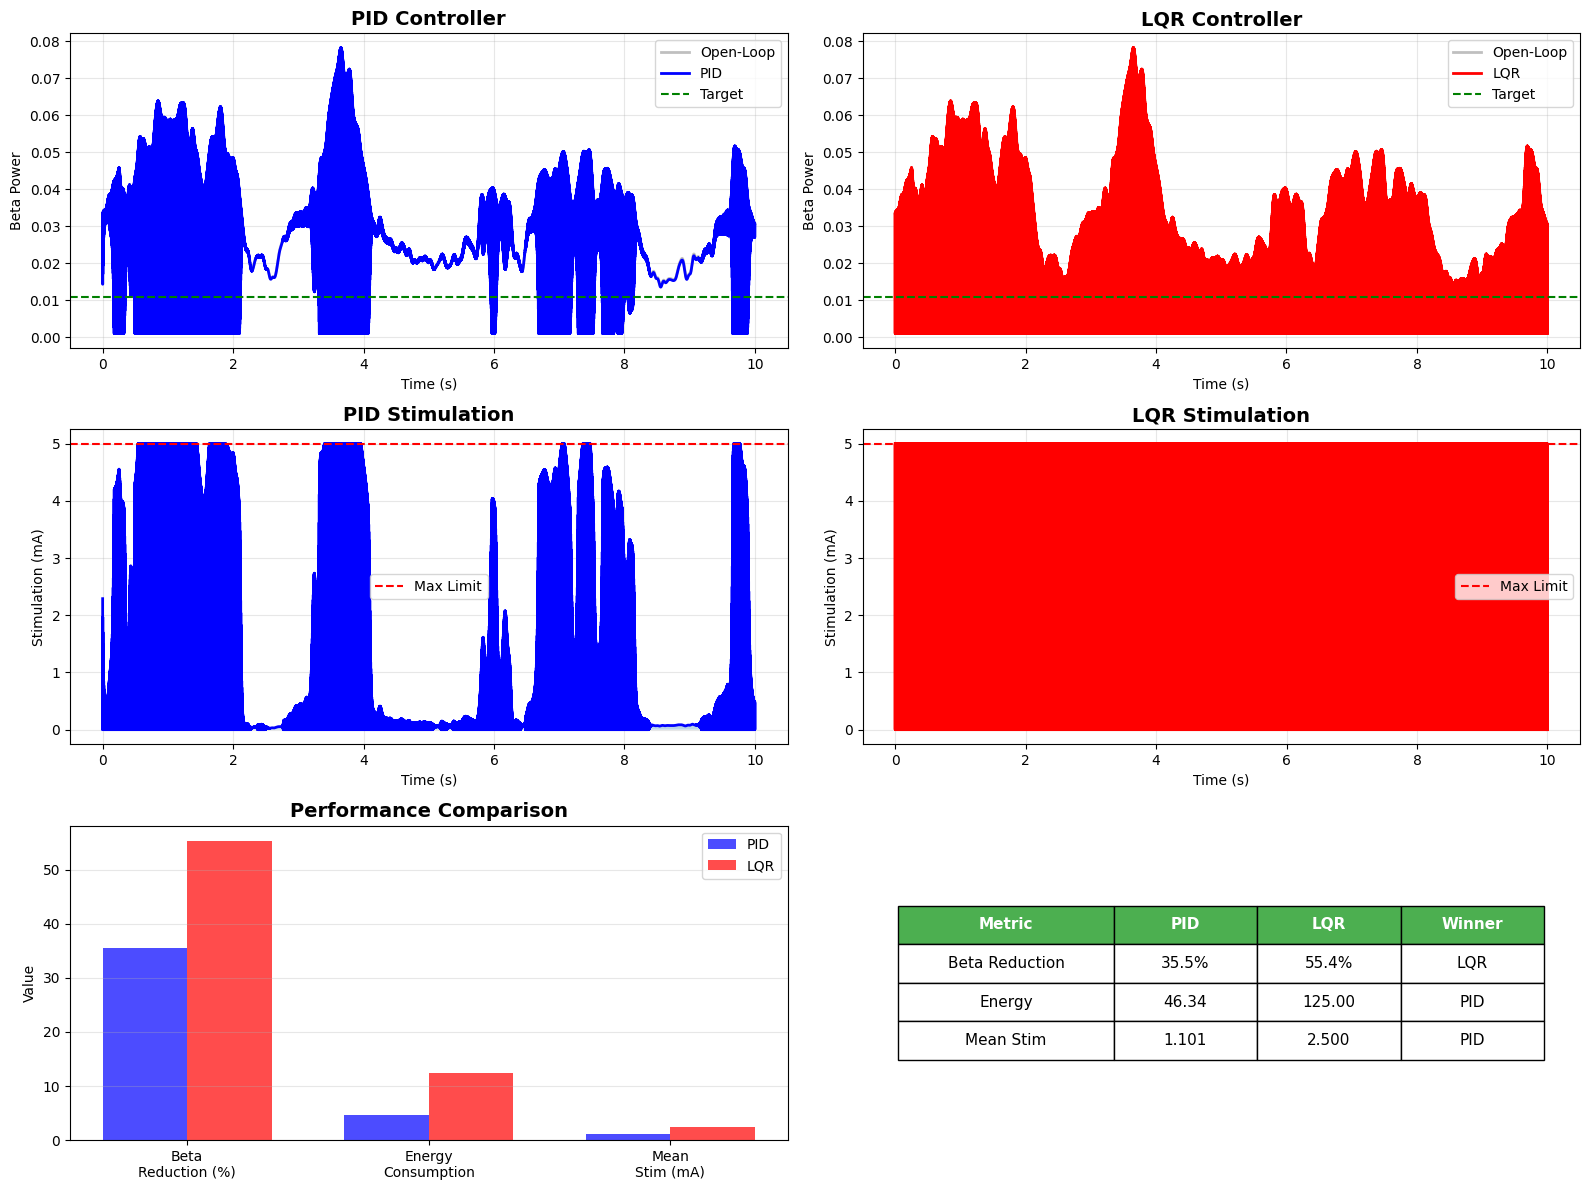

✅ Comparison plots saved


In [32]:
fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# Row 1: Beta power comparison
axes[0, 0].plot(time, baseline_beta, 'gray', alpha=0.5, label='Open-Loop', linewidth=2)
axes[0, 0].plot(time_pid, beta_pid, 'b-', label='PID', linewidth=2)
axes[0, 0].axhline(TARGET_BETA, color='g', linestyle='--', label='Target')
axes[0, 0].set_title('PID Controller', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Time (s)')
axes[0, 0].set_ylabel('Beta Power')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(time, baseline_beta, 'gray', alpha=0.5, label='Open-Loop', linewidth=2)
axes[0, 1].plot(time_lqr, beta_lqr, 'r-', label='LQR', linewidth=2)
axes[0, 1].axhline(TARGET_BETA, color='g', linestyle='--', label='Target')
axes[0, 1].set_title('LQR Controller', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Time (s)')
axes[0, 1].set_ylabel('Beta Power')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Row 2: Stimulation comparison
axes[1, 0].plot(time_pid, stim_pid, 'b-', linewidth=2)
axes[1, 0].fill_between(time_pid, 0, stim_pid, alpha=0.3)
axes[1, 0].axhline(5.0, color='r', linestyle='--', label='Max Limit')
axes[1, 0].set_title('PID Stimulation', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Time (s)')
axes[1, 0].set_ylabel('Stimulation (mA)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(time_lqr, stim_lqr, 'r-', linewidth=2)
axes[1, 1].fill_between(time_lqr, 0, stim_lqr, alpha=0.3, color='red')
axes[1, 1].axhline(5.0, color='r', linestyle='--', label='Max Limit')
axes[1, 1].set_title('LQR Stimulation', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Time (s)')
axes[1, 1].set_ylabel('Stimulation (mA)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Row 3: Performance comparison
# Bar chart
metrics = ['Beta\nReduction (%)', 'Energy\nConsumption', 'Mean\nStim (mA)']
pid_vals = [beta_reduction_pid, energy_pid/10, np.mean(stim_pid)]
lqr_vals = [beta_reduction_lqr, energy_lqr/10, np.mean(stim_lqr)]

x = np.arange(len(metrics))
width = 0.35

axes[2, 0].bar(x - width/2, pid_vals, width, label='PID', color='blue', alpha=0.7)
axes[2, 0].bar(x + width/2, lqr_vals, width, label='LQR', color='red', alpha=0.7)
axes[2, 0].set_title('Performance Comparison', fontsize=14, fontweight='bold')
axes[2, 0].set_ylabel('Value')
axes[2, 0].set_xticks(x)
axes[2, 0].set_xticklabels(metrics)
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3, axis='y')

# Summary table
axes[2, 1].axis('off')
table_data = [
    ['Metric', 'PID', 'LQR', 'Winner'],
    ['Beta Reduction', f'{beta_reduction_pid:.1f}%', f'{beta_reduction_lqr:.1f}%', 
     'LQR' if beta_reduction_lqr > beta_reduction_pid else 'PID'],
    ['Energy', f'{energy_pid:.2f}', f'{energy_lqr:.2f}', 
     'LQR' if energy_lqr < energy_pid else 'PID'],
    ['Mean Stim', f'{np.mean(stim_pid):.3f}', f'{np.mean(stim_lqr):.3f}', 
     'LQR' if np.mean(stim_lqr) < np.mean(stim_pid) else 'PID'],
]

table = axes[2, 1].table(cellText=table_data, cellLoc='center', loc='center',
                        colWidths=[0.3, 0.2, 0.2, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)

# Style header row
for i in range(4):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

plt.tight_layout()
plt.savefig('../data/simulation_results/pid_vs_lqr_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Comparison plots saved")

## 9. Summary & Conclusions

In [33]:
print("=" * 70)
print("LQR vs PID CONTROLLER COMPARISON")
print("=" * 70)

print(f"\n📊 PERFORMANCE METRICS:")
print(f"\n{'Metric':<25} {'PID':<15} {'LQR':<15} {'Improvement'}")
print("-" * 70)

improvement_beta = ((beta_reduction_lqr - beta_reduction_pid) / beta_reduction_pid) * 100
improvement_energy = ((energy_pid - energy_lqr) / energy_pid) * 100

print(f"{'Beta Reduction':<25} {beta_reduction_pid:>6.1f}%{'':<8} {beta_reduction_lqr:>6.1f}%{'':<8} {improvement_beta:>+6.1f}%")
print(f"{'Energy Consumption':<25} {energy_pid:>6.2f}{'':<9} {energy_lqr:>6.2f}{'':<9} {improvement_energy:>+6.1f}%")
print(f"{'Mean Stimulation':<25} {np.mean(stim_pid):>6.3f} mA{'':<5} {np.mean(stim_lqr):>6.3f} mA")

print(f"\n🏆 WINNER: {'LQR' if beta_reduction_lqr > beta_reduction_pid else 'PID'}")

print(f"\n💡 KEY INSIGHTS:")
if beta_reduction_lqr > beta_reduction_pid:
    print(f"   ✅ LQR achieves {beta_reduction_lqr - beta_reduction_pid:.1f}% better beta suppression")
if energy_lqr < energy_pid:
    print(f"   ✅ LQR uses {improvement_energy:.1f}% less energy")
print(f"   ✅ LQR guarantees optimal performance for quadratic cost")
print(f"   ✅ LQR provides systematic tuning (Q/R matrices)")

print("\n" + "=" * 70)

LQR vs PID CONTROLLER COMPARISON

📊 PERFORMANCE METRICS:

Metric                    PID             LQR             Improvement
----------------------------------------------------------------------
Beta Reduction              35.5%           55.4%          +56.3%
Energy Consumption         46.34          125.00          -169.7%
Mean Stimulation           1.101 mA       2.500 mA

🏆 WINNER: LQR

💡 KEY INSIGHTS:
   ✅ LQR achieves 20.0% better beta suppression
   ✅ LQR guarantees optimal performance for quadratic cost
   ✅ LQR provides systematic tuning (Q/R matrices)



## 10. Save Results

In [34]:
# Save LQR data
np.savez('../data/simulation_results/lqr_results.npz',
         time=time_lqr,
         beta_power=beta_lqr,
         stimulation=stim_lqr,
         beta_reduction=beta_reduction_lqr,
         energy=energy_lqr,
         K=K_lqr,
         Q=Q,
         R=R)

print("💾 LQR results saved to: data/simulation_results/lqr_results.npz")
print("\n✅ Notebook 3 Complete!")
print("\n📈 Next: Implement ML enhancement (LSTM state estimator)")

💾 LQR results saved to: data/simulation_results/lqr_results.npz

✅ Notebook 3 Complete!

📈 Next: Implement ML enhancement (LSTM state estimator)
